In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

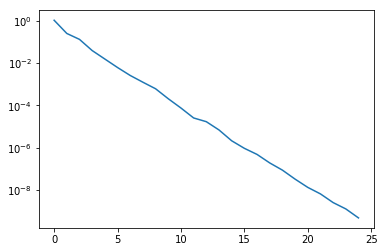

True

In [2]:
def jacobi(A, b, tol, maxiters, plot=False):
    n = b.shape[0]
    x_0 = np.zeros(n)
    D_inv = np.diag(1 / np.diag(A))
    current_iter = 0
    error_list = []
    while current_iter < maxiters:
        x_1 = x_0 + D_inv@(b - A@x_0)
        error_list.append(norm(b - A@x_1, ord=np.inf))
        if norm(x_1 - x_0, ord=np.inf) < tol:
            if plot:
                plt.semilogy(range(current_iter + 1), error_list)
                plt.show()
            return x_1
        x_0 = x_1
        current_iter += 1
    if plot:
        plt.semilogy(range(current_iter + 1), error_list)
        plt.show()
    return x_1

def diag_dom(n, num_entries=None):
    """Generate a strictly diagonally dominant (n, n) matrix.
    Parameters:
        n (int): The dimension of the system.
        num_entries (int): The number of nonzero values.
            Defaults to n^(3/2)-n.
    Returns:
        A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
    """
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

A = diag_dom(100)
b = np.random.random(100)
x = jacobi(A, b, 1e-10, 1000, plot=True)

np.allclose(A@x, b)

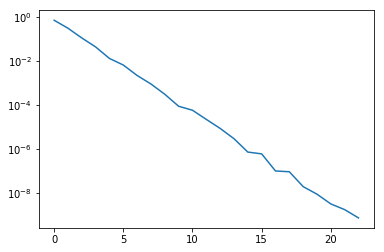

True

In [3]:
def GS(A, b, tol, maxiters, plot=False):
    n = b.shape[0]
    x_0 = np.zeros(n)
    diag = 1 / np.diag(A)
    current_iter = 0
    error_list = []
    while current_iter < maxiters:
        x_1 = np.empty(n)
        for i in range(n):
            x_1[i] = x_0[i] + diag[i]*(b[i] - A[i, :]@x_0)
        error_list.append(norm(b - A@x_1, ord=np.inf))
        if norm(x_1 - x_0, ord=np.inf) < tol:
            if plot:
                plt.semilogy(range(current_iter + 1), error_list)
                plt.show()
            return x_1
        x_0 = x_1
        current_iter += 1
    if plot:
        plt.semilogy(range(current_iter + 1), error_list)
        plt.show()
    return x_1

A = diag_dom(100)
b = np.random.random(100)
x = GS(A, b, 1e-10, 1000, plot=True)

np.allclose(A@x, b)

In [4]:
def GS_sparse(A, b, tol, maxiters):
    n = b.shape[0]
    x_0 = np.zeros(n)
    diag = 1 / A.diagonal()
    current_iter = 0
    while current_iter < maxiters:
        x_1 = np.empty(n)
        for i in range(n):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix_0 = A.data[rowstart:rowend] @ x_0[A.indices[rowstart:rowend]]
            x_1[i] = x_0[i] + diag[i]*(b[i] - Aix_0)
        if norm(x_1 - x_0, ord=np.inf) < tol:
            return x_1
        x_0 = x_1
        current_iter += 1
    return x_1

A = sparse.csr_matrix(diag_dom(100))
b = np.random.random(100)
x = GS_sparse(A, b, 1e-10, 1000)

np.allclose(A@x, b)

True

In [ ]:
def SOR(A, b, omega, tol, maxiters):
    if type(A) != sparse.csr_matrix:   
        A=sparse.csr_matrix(A)
    n = b.shape[0]
    x_0 = np.zeros(n)
    x_1 = np.empty(n)
    current_iter = 0
    while current_iter < maxiters:
        for i in range(n):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix_0 = A.data[rowstart:rowend] @ x_0[A.indices[rowstart:rowend]]
            x_1[i] = x_0[i] + (omega / A[i, i]) * (b[i] - Aix_0)
        if norm(x_1 - x_0, ord=np.inf) < tol:
            return x_1, current_iter
        x_0 = np.copy(x_1)
        current_iter += 1
    return x_1, current_iter

A = sparse.csr_matrix(diag_dom(100))
b = np.random.random(100)
x1, num_iters1 = SOR(A, b, 1, 1e-10, 1000)
x2, num_iters2 = SOR(A, b, 1.05, 1e-10, 1000)


#Seems to consistently take more iterations with the relaxation factor...
print(np.allclose(A@x1, b))
print(num_iters1, 'iterations')
print(np.allclose(A@x2, b))
print(num_iters2, 'iterations')

In [ ]:
def FDM(n, omega, tol=10e-8, maxiters=100, plot=False):
    diag_ones = np.ones(n-1)
    diag_neg_fours = -4*np.ones(n)
    B = sparse.diags((diag_ones, diag_neg_fours, diag_ones), (-1, 0, 1), shape=(n,n))
    I = sparse.identity(n)
    A_list = []
    for i in range(n):
        if i == 0:
            A_list.append([B, I] + [None]*(n - 2))
        elif i == n - 1:
            A_list.append([None]*(n - 2) + [I, B])
        else:
            A_list.append([None]*(i - 1) + [I, B, I] + [None]*((n - 3) - (i - 1)))
    A = sparse.bmat(A_list, format='bsr')
    b = np.tile(np.array([-100] + [0]*(n - 2) + [-100]), n)
    solution, num_iters = SOR(A, b, omega, tol, maxiters)
    solution = solution.reshape((n, n))
    if plot:
        x_domain = np.linspace(0, 1, n + 1)
        y_domain = np.linspace(0, 1, n + 1)
        X, Y = np.meshgrid(x_domain, y_domain)
        plt.pcolormesh(X, Y, solution, cmap='coolwarm')
        plt.colorbar()
        plt.show()
    return solution, num_iters

FDM(100, 1, plot=True, maxiters=1000)

In [ ]:
domain = np.linspace(1, 1.95, 20)
iterations = [FDM(4, omega, tol=1e-2, maxiters=1000)[1] for omega in domain]
plt.plot(domain, iterations)
plt.show()
print('Optimal relaxation factor:', domain[np.argmin(iterations)])